<font size = "5"> **[Image Tools](2_Image_Tools.ipynb)** </font>

<hr style="height:2px;border-top:4px solid #FF8200" />


# Registration of a Stack of Images 

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Imaging/Image_Registration.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Imaging/Image_registration.ipynb)

by 

Gerd Duscher

Materials Science & Engineering<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

We us this notebook **only** for a stack of images.


## Install pyTEMlib

If you have not done so in the [Introduction Notebook](1_Correcting_Image_Distortions.ipynb), please install [pyTEMlib](https://github.com/gduscher/pyTEMlib) with the code cell below.

In [1]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2025.2.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
print('done')


done


## Import the usual libraries


You'll need at least pyTEMlib version 0.2020.04.2

You can load that library with the code cell above:

In [4]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt 
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

import sys
sys.path.insert(0, '../../')
%load_ext autoreload
%autoreload 2
if 'google.colab' in sys.modules:
    drive.mount("/content/drive")

import pyTEMlib.file_tools      # File input/ output library
import pyTEMlib.image_tools 
import pyTEMlib.probe_tools
import pyTEMlib.atom_tools

    
# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ', pyTEMlib.__version__)

## Do all of registration

notebook_tags= {'notebook': 'Image_Registration',
                'notebook_version': '2025_03_13',
                'pyTEM version': pyTEMlib.__version__}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
pyTEM version:  0.2025.02.2


## Load an image stack :

Please, load an image stack. <br>

A stack of images is used to reduce noise, but for an added image the images have to be aligned to compensate for drift and other microscope instabilities.

You select here (with the ``Select Main`` button,) a file of your image.

Note that the **Add** should only used for reference data

In [ ]:
fileWidget = pyTEMlib.file_tools.FileWidget()


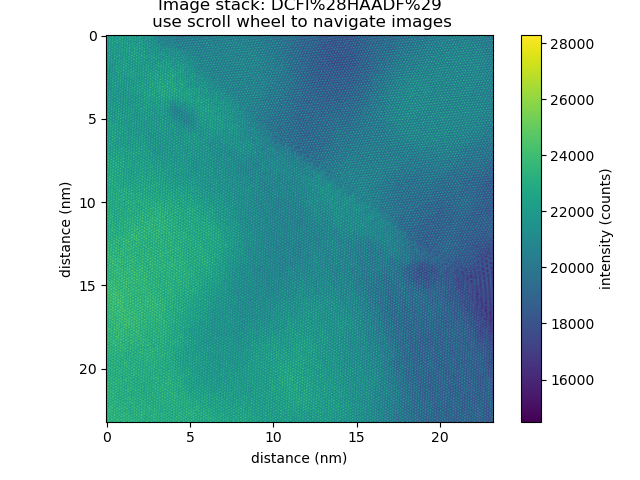

In [7]:
dataset = fileWidget.selected_dataset
view = dataset.plot()

Some of the metadata is available in the ``metadata`` attribute of the dataset but all information can be found in ``original metadata``.

## Complete Registration 

Takes a while, depending on your computer between 1 and 10 minutes

### Rigid Registration

Using sub-pixel accuracy registration determination method of:

Manuel Guizar-Sicairos, Samuel T. Thurman, and James R. Fienup, “Efficient subpixel image registration algorithms,” Optics Letters 33, 156-158 (2008). [DOI:10.1364/OL.33.000156](https://www.doi.org/%2010.1364/OL.33.000156)

as implemented in ``phase_cross_correlation`` function by ``scikit-image`` in the [registration](https://scikit-image.org/docs/dev/api/skimage.registration.html) package. 

In [8]:
rigid_registered_dataset = pyTEMlib.image_tools.rigid_registration(dataset)

Stack contains  10  images, each with 1024  pixels in x-direction and  1024  pixels in y-direction


  0%|          | 0/10 [00:00<?, ?it/s]

### Non-Rigid Registration

Here we use the **Diffeomorphic Demon Non-Rigid Registration** as provided by **simpleITK**.  

Please Cite: 
* [simpleITK](http://www.simpleitk.org/SimpleITK/project/parti.html)
    
    and
    
* [T. Vercauteren, X. Pennec, A. Perchant and N. Ayache *Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy* The Insight Journal, 2007](http://hdl.handle.net/1926/510)

In [ ]:
non_rigid_registered = pyTEMlib.image_tools.demon_registration(rigid_registered_dataset)

  0%|          | 0/10 [00:00<?, ?it/s]

Or do it all together

In [ ]:
demon_registered, rigid_registered = pyTEMlib.image_tools.complete_registration(dataset)
demon_registered.data_type = 'image_stack'
view2 = demon_registered.plot()

Rigid_Registration
Stack contains  10  images, each with 1024  pixels in x-direction and  1024  pixels in y-direction


  0%|          | 0/10 [00:00<?, ?it/s]

sidpy.Dataset of type IMAGE_STACK with:
 dask.array<array, shape=(10, 1023, 1022), dtype=float64, chunksize=(10, 1023, 1022), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
frame:  time (frame) of size (10,)
x:  Length (nm) of size (1023,)
y:  Length (nm) of size (1022,)
 with metadata: ['analysis', 'drift', 'input_crop', 'input_shape', 'experiment']
Non-Rigid_Registration


  0%|          | 0/10 [00:00<?, ?it/s]

You will need to zoom in to see that the images are changing.

Compare this to the rigid registered stack

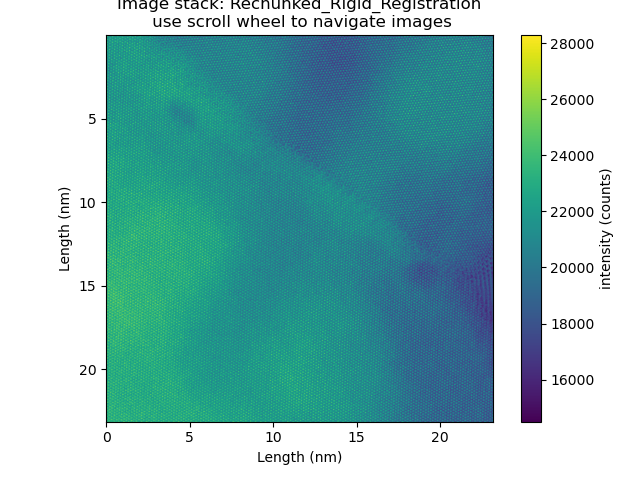

In [12]:
view3 = rigid_registered.plot()

### Check Drift

In [ ]:
drift = rigid_registered.metadata['drift']
polynom_degree = 2 # 1 is linear fit, 2 is parabolic fit, ...

x = np.linspace(0,drift.shape[0]-1,drift.shape[0])

line_fit_x = np.polyfit(x, drift[:,0], polynom_degree)
poly_x = np.poly1d(line_fit_x)
line_fit_y = np.polyfit(x, drift[:,1], polynom_degree)
poly_y = np.poly1d(line_fit_y)

plt.figure()
plt.axhline(color = 'gray')
plt.plot(x, drift[:,0], label = 'drift x')
plt.plot(x, drift[:,1], label = 'drift y')
plt.plot(x, poly_x(x),  label = 'fit_drift_x')
plt.plot(x, poly_y(x),  label = 'fit_drift_y')

plt.legend();
ax_pixels = plt.gca()
ax_pixels.step(1, 1)

scaleX = (rigid_registered.x[1]-rigid_registered.x[0])*1000.  #in pm

ax_pm = ax_pixels.twinx()
x_1, x_2 = ax_pixels.get_ylim()

ax_pm.set_ylim(x_1*scaleX, x_2*scaleX)

ax_pixels.set_ylabel('drift [pixels]')
ax_pm.set_ylabel('drift [pm]')
ax_pixels.set_xlabel('image number');
plt.tight_layout()


## Find Atom Positions
### Lucy -Richardson Deconvolution

Lucy - Richardson Deconvolution removes noise and convolutes the intensity back into the atom (columns).

Here we use a slightly modified Lucy - Richardson Deconvolution which stops when converged.

Ideally the atom_size should be as large as the atoms in the image.

A good Lucy-Richardson Deconvolution should result in an image with atoms of a radius of about 2 pixels.

The number of steps to convergence should be less than 300 for a good approximation of atom_size.
> we use the non-rigid registered datset


0.6245036676024621
smal
3 0.04803814862316707
Deconvolution of  HAADF


  0%|          | 0/500 [00:00<?, ?it/s]

converged in 129 iterations

 Lucy-Richardson deconvolution converged in 129  iterations


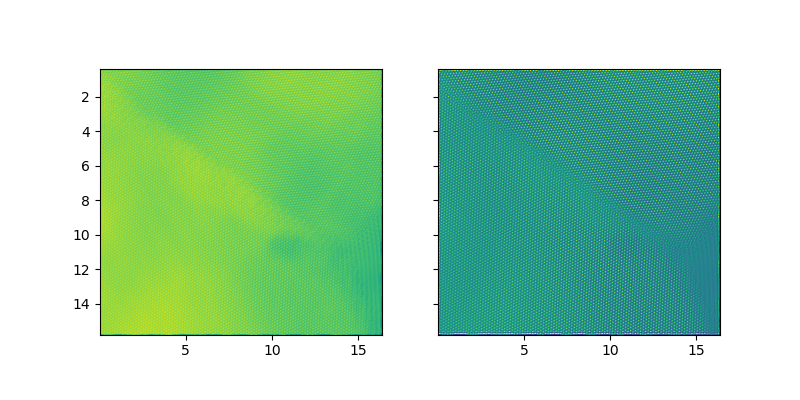

In [26]:
# ------- Input ------
atoms_size = 0.1 # in nm
# --------------------

image = demon_registered.sum(axis=0)

out_tags = {}
image.metadata['experiment']= {'convergence_angle': 30, 'acceleration_voltage': 200000.}

scale_x = image.x[1] - image.x[0]
gauss_diameter = atoms_size/scale_x
print(gauss_diameter)
if gauss_diameter < 3:
    print('smal')
    gauss_diameter = 3
print(gauss_diameter, gauss_diameter*scale_x)
gauss_probe = pyTEMlib.probe_tools.make_gauss(image.shape[0], image.shape[1], gauss_diameter)

print('Deconvolution of ', dataset.title)
LR_dataset = pyTEMlib.image_tools.decon_lr(image, gauss_probe, verbose=False)

extent = LR_dataset.get_extent([0,1])
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image.T, extent = extent,vmax=np.median(np.array(image))+3*np.std(np.array(image)))
ax[1].imshow(LR_dataset.T, extent = extent, vmax=np.median(np.array(LR_dataset))+3*np.std(np.array(LR_dataset)));

### Log Deconvolution

In [10]:
LR_dataset.metadata = {'analysis': 'Lucy_Richardson',
                        'name': 'Lucy_Richardson',
                        'notebook': __notebook__ ,
                        'notebook_version': __notebook_version__,
                        'input': dataset.title,
                        'probe_diameter': gauss_diameter,
                        'kind_of_probe': 'Gauss',
                        'probe_width': atoms_size
                        }
                          
image_channel = ft.log_results(current_channel, dataset=LR_dataset)

current_channel.file.flush()

for key in current_channel:
    if 'Log' in key:
        if 'analysis' in dict(current_channel[key]).keys():
            print(f"{key} includes analysis: {current_channel[key]['analysis'][()]}")

## Atom Detection

Choose threshold and atom size so that all atoms or at least all bright atoms of an unit cell are found 

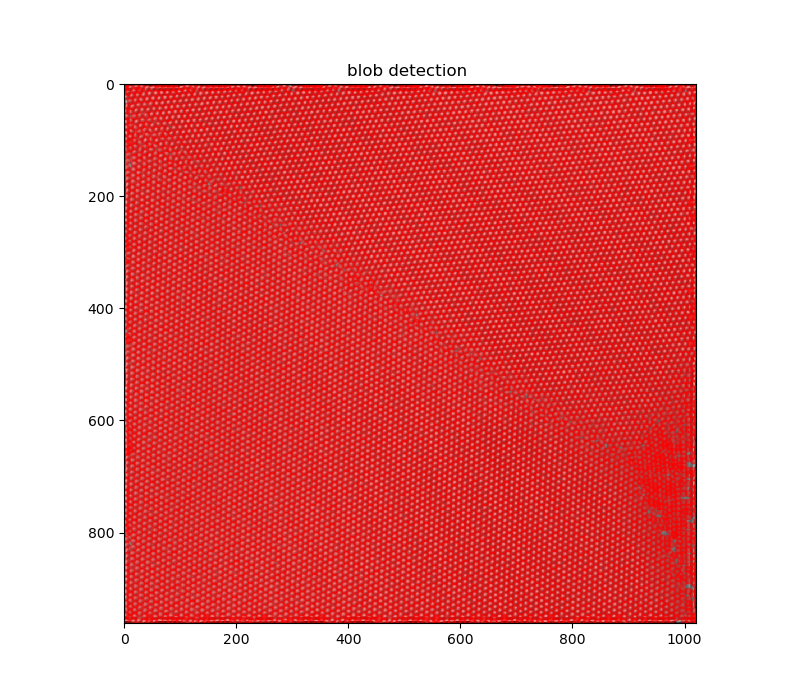

In [30]:
import skimage
# ------- Input ------
threshold = 0.9 #usally between 0.01 and 0.9  the smaller the more atoms
atom_size = .06 #in nm  
# ----------------------


image = LR_dataset
#image = image_choice.dataset
# scale_x = pyTEMlib.file_tools.get_slope(image.dim_1)
blobs =  skimage.feature.blob_log(image, max_sigma=atom_size/scale_x, threshold=threshold)

fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
plt.title("blob detection ")

plt.imshow(image.T, interpolation='nearest',cmap='gray', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
plt.scatter(blobs[:, 0], blobs[:, 1], c='r', s=20, alpha = .5);

#### Log Atom Positions

In [13]:
out_tags  =  {}
out_tags['analysis']= 'Atom Positions'
out_tags['notebook']= __notebook__ 
out_tags['notebook_version']= __notebook_version__

out_tags['atoms'] = blobs
out_tags['atom_size'] = atom_size #in nm gives the size of the atoms or resolution
out_tags['threshold'] =  threshold  #between 0.01 and 0.1 
out_tags['pixel_size'] = scale_x


out_tags['name'] = 'Atom finding'
out_tags['title'] = out_tags['name']

atom_group = ft.log_results(current_channel, attributes=out_tags)

for key in current_channel:
    if 'Log' in key:
        if 'analysis' in current_channel[key]:
            print(f"{key} includes analysis: {current_channel[key]['analysis'][()]}")

Log_003 includes analysis: b'Atom Positions'


### Refine All Atom Positions
Fitting of a Gaussian into the center of an atom

There will be convergence errors if the atom_radius value is too large or too small

In [27]:
image_choice = ft.ChooseDataset(current_channel)  

Dropdown(description='select dataset:', options=('Recording of SuperScan (HAADF)', 'Rigid Registration', 'Non_…

sidpy.Dataset of type IMAGE_STACK with:
 dask.array<sub, shape=(512, 512), dtype=float64, chunksize=(512, 512), chunktype=numpy.ndarray>
 data contains: generic (generic)
 and Dimensions: 
y:  distance (nm) of size (512,)
x:  distance (nm) of size (512,)
 with metadata: ['metadata', 'original_metadata']
using radius  3 pixels


  0%|          | 0/799 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


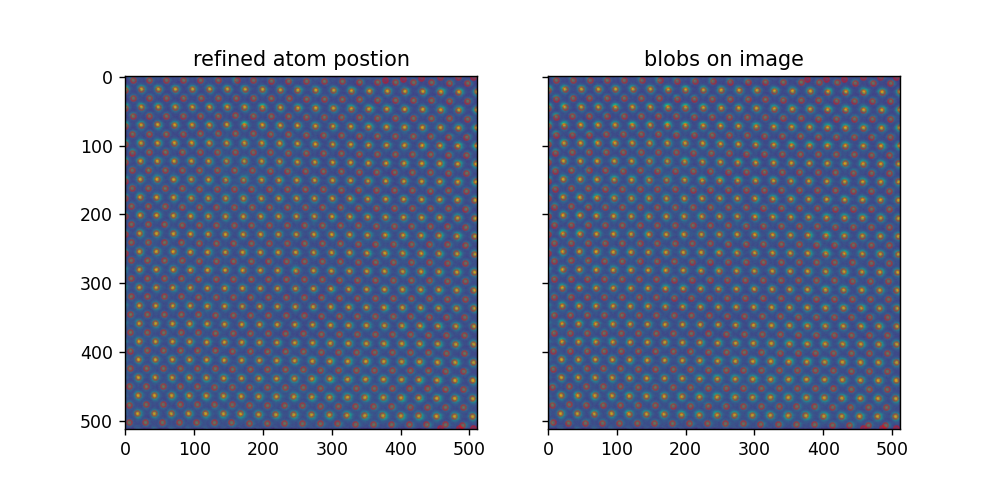

In [30]:
# ------- Input ------
atom_radius = 3  # in pixel
# ----------------------

if image_choice.dataset.data_type.name == 'IMAGE_STACK':
    image = image_choice.dataset.sum(axis=0)
else:
    image = image_choice.dataset

#atoms = atom_group['atoms'][()]
atoms = blobs
image = image-image.min()
print(image)

#atom_radius = 2
MaxInt = 0
MinInt = 0 
maxDist = 2
sym = pyTEMlib.atom_tools.atom_refine(np.array(image), atoms, atom_radius, max_int = 0, min_int = 0, max_dist = 2)
refined_atoms = np.array(sym['atoms'])

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image.T)
ax[0].scatter(refined_atoms[:,0],refined_atoms[:,1],  s=10, alpha = 0.3, color = 'red')
ax[0].set_title('refined atom postion')
ax[1].imshow(image.T)
ax[1].scatter(atoms[:, 0], atoms[:, 1], c='r', s=10, alpha = .3);
ax[1].set_title('blobs on image');

## Close  File

Close file when finished and everyhting went well.

In [35]:
h5_file = dataset.h5_dataset.file

print(h5_file.filename)
h5_file.close()

C:/Users/gduscher/Documents/Github/Image_Distortion\Recording of SuperScan (HAADF)-3.hf5


## Appendix

### Demon Registration

Here we use the **Diffeomorphic Demon Non-Rigid Registration** as provided by **simpleITK**.  

Please Cite: 
* [simpleITK](http://www.simpleitk.org/SimpleITK/project/parti.html)
    
    and
    
* [T. Vercauteren, X. Pennec, A. Perchant and N. Ayache *Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy* The Insight Journal, 2007](http://hdl.handle.net/1926/510)

This Non-Rigid Registration consists of the following steps:

- determine ``reference`` image
    - For this we use the average of the rigid registered stack
    - this averaged stack is then smeared with a Gaussian of sigma 2 pixel to reduce noise
    - under the assumption that high frequency scan distortions cancel out over several images, we, therefore, obtained the center of mass of the atoms. 

- perform the ``demon registration`` filter to determine a distortion matrix
    - each single image of a stack is first smeared with a Gaussian of sigma of 2pixels
    - then the deformation matrix is determined for these images
    - the deformation matrix is a matrix where each pixel has a vector ( x, and y value) for the relative shift of this pixel.
    
- This deformation matrix is used to ``transform`` the image
	- The transformation is performed on the original image.
	- Important, here, is to set the interpolator method, (the image needs to be interpolated because the new pixels are not on an integer grid.)
    
    
Let's see what the different interpolators do.

|Method	| RMS contrast |	Standard |	Mean |
|-------|:--------------|:-------------|:-------|
|original   |0.1965806	|0.07764114	|0.3949583
|Linear	    |0.20159315	|0.079470366	|0.39421165
|BSpline	|0.20162606	|0.0794831 	|0.39421043
|Gaussian	|0.14310582	|0.056414302 	|0.39421389
|Hamming	|0.20163293	|0.07948672 	|0.39421496

The Gaussian interpolator as the only one seems to smear the signal.

We will use the ``Bspline`` method a fast and simple method that does not introduce spurious features and does not smear the signal.


#### Full Code of Demon registration 

In [ ]:
import simpleITK as sitk

def DemonReg(cube, verbose = False):
    """
    Diffeomorphic Demon Non-Rigid Registration 
    Usage:
    ------
    DemReg = DemonReg(cube, verbose = False)

    Input:
        cube: stack of image after rigid registration and cropping
    Output:
        DemReg: stack of images with non-rigid registration

    Dempends on:
        simpleITK and numpy
    
    Please Cite: http://www.simpleitk.org/SimpleITK/project/parti.html
    and T. Vercauteren, X. Pennec, A. Perchant and N. Ayache
    Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy
    The Insight Journal, http://hdl.handle.net/1926/510 2007
    """
    
    DemReg =  np.zeros_like(cube)
    nimages = cube.shape[0]
    print(nimages)
    # create fixed image by summing over rigid registration

    fixed_np = np.average(current_dataset, axis=0)

    fixed = sitk.GetImageFromArray(fixed_np)
    fixed = sitk.DiscreteGaussian(fixed, 2.0)

    #demons = sitk.SymmetricForcesDemonsRegistrationFilter()
    demons = sitk.DiffeomorphicDemonsRegistrationFilter()

    demons.SetNumberOfIterations(200)
    demons.SetStandardDeviations(1.0)

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed);
    resampler.SetInterpolator(sitk.sitkBspline)
    resampler.SetDefaultPixelValue(0)

    done = 0
        
    for i in range(nimages):
        if done < int((i+1)/nimages*50):
            done = int((i+1)/nimages*50)
            sys.stdout.write('\r')
            # progress output :
            sys.stdout.write("[%-50s] %d%%" % ('*'*done, 2*done))
            sys.stdout.flush()
        
        moving = sitk.GetImageFromArray(cube[i])
        movingf = sitk.DiscreteGaussian(moving, 2.0)
        displacementField = demons.Execute(fixed,movingf)
        outTx = sitk.DisplacementFieldTransform( displacementField )
        resampler.SetTransform(outTx)
        out = resampler.Execute(moving)
        DemReg[i,:,:] = sitk.GetArrayFromImage(out)
        #print('image ', i)
        
    
    print(':-)')
    print('You have succesfully completed Diffeomorphic Demons Registration')
    
    return DemReg
